In [1]:
from SSSCSP import PackingCONST, GetData
import warnings
import types
import sys
import numpy as np
import time
from func_timeout import func_timeout, FunctionTimedOut


import os
import json






def evaluate(
    problem_instance, base_code_str, definitions_to_exec_list, class_to_instantiate_name
):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Create a unique module name to avoid conflicts if run multiple times
            module_name_suffix = "".join(filter(str.isalnum, class_to_instantiate_name))
            module_name = f"packing_module_{module_name_suffix}_{str(time.time_ns())}"

            packing_module = types.ModuleType(module_name)
            sys.modules[module_name] = packing_module  # Register the module

            # Execute base code first, always
            if base_code_str and base_code_str.strip():
                exec(base_code_str, packing_module.__dict__)

            # Execute all class definitions provided, in order
            for i, code_def in enumerate(definitions_to_exec_list):
                try:
                    exec(code_def, packing_module.__dict__)
                except Exception as e_exec:
                    error_msg = (
                        f"Error executing definition for class '{class_to_instantiate_name}' or its ancestor. "
                        f"Problem in segment {i+1} of definitions. Error: {type(e_exec).__name__}: {str(e_exec)}\n"
                    )
                    # print(f"Debug: {error_msg}") # Debug
                    return (None, error_msg, packing_module)

            # Instantiate the target class
            if not hasattr(packing_module, class_to_instantiate_name):
                error_msg = f"Class '{class_to_instantiate_name}' not found in module after executing definitions."
                return (None, error_msg, packing_module)

            AlgorithmClass = getattr(packing_module, class_to_instantiate_name)

            try:
                algorithm = AlgorithmClass()  # Potential __init__ error here
            except Exception as e_init:
                error_msg = f"Error during instantiation of '{class_to_instantiate_name}': {type(e_init).__name__}: {str(e_init)}"
                return (None, error_msg, packing_module)

            # Call greedy method from the problem_instance
            all_container_count = 0
            all_container = []
            for item_types, container_type in packing_problem.instance_data:
                container_count, status = packing_problem.solve_instance(
                    algorithm.place_item, item_types, container_type
                )
                all_container_count += container_count
                all_container.append(container_count)
            # Unregister module after use to prevent pollution if many iterations
            # del sys.modules[module_name] # Be cautious if module objects are stored elsewhere
            print(all_container)
            return (all_container_count, status, packing_module)

    except Exception as e_eval_setup:
        # Catch-all for other unexpected errors during evaluation setup
        error_msg = f"Broader evaluation setup error for '{class_to_instantiate_name}': {type(e_eval_setup).__name__}: {str(e_eval_setup)}"
        # print(f"Debug: {error_msg}") # Debug
        return (None, error_msg, None)


packing_problem = PackingCONST()
getData = GetData(47)
packing_problem.instance_data = getData.generate_instances()
base_class_code = packing_problem.base_class_code
all_infos = []
def get_fitness(code_dict):
    class_names = ["Algorithm", "AlgorithmIT1", "AlgorithmIT2", "AlgorithmIT3"]

    llm_generated_code_fix = None  # Will hold the code from the LLM for IT1, IT2 etc.
    final_successful_code_block = None
    final_fitness_achieved = None


    current_class_to_instantiate = code_dict["class_name"]
    code_for_current_class = llm_generated_code_fix

    definitions_for_eval = [code_dict["code"]]
    start_time = time.time()
    fitness_val, error_msg_eval, _ = evaluate(packing_problem,
        base_class_code,
        definitions_for_eval,
        current_class_to_instantiate,
    )
    return fitness_val
all_fitness = {}
for budget_time in [10,60]:
    all_fitness[budget_time] = []
    for seed in range(3):
        i=10
        code_file_path = f"paper_output/{budget_time}_{seed}/results/pops/population_generation_{i}.json"
        with open(code_file_path, "r") as file:
            all_codes = json.load(file)

        code_dict = all_codes[0]  # Assuming we want the first code block for evaluation
        crappy_code = code_dict["code"]
        objective = code_dict["objective"]
        previous_code = crappy_code
        fitness = get_fitness(code_dict)
        all_fitness[budget_time].append((fitness,objective))
for budget_time in [10,60]:
    for seed in range(3):
        print(f"Budget time: {budget_time}, Seed: {seed}, Test: {all_fitness[budget_time][seed][0]-all_fitness[budget_time][seed][1]*20}, Train: {all_fitness[budget_time][seed][1]*20}")

Successfully processed 20 instances.
Successfully processed 47 instances.
[25, 10, 23, 28, 53, 10, 16, 4, 22, 55, 18, 56, 27, 27, 15, 33, 10, 2, 3, 5, 26, 10, 21, 7, 5, 3, 5, 12, 21, 28, 14, 4, 5, 11, 3, 14, 23, 45, 18, 12, 23, 5, 4, 4, 3, 2, 4]
[25, 10, 24, 28, 52, 10, 16, 4, 22, 55, 18, 56, 27, 27, 14, 33, 10, 2, 3, 5, 26, 11, 21, 7, 6, 4, 5, 12, 21, 28, 14, 4, 5, 11, 3, 14, 23, 45, 18, 12, 23, 5, 4, 4, 3, 2, 4]
[26, 10, 22, 31, 52, 10, 16, 5, 19, 55, 22, 56, 27, 28, 15, 34, 9, 2, 4, 5, 25, 11, 21, 8, 5, 4, 6, 12, 21, 27, 16, 4, 5, 9, 3, 14, 23, 45, 18, 10, 23, 7, 4, 4, 3, 2, 4]
[25, 10, 19, 27, 51, 10, 16, 4, 19, 55, 19, 53, 40, 28, 12, 32, 8, 3, 3, 6, 22, 10, 22, 6, 6, 4, 5, 10, 19, 30, 15, 6, 5, 9, 3, 17, 23, 45, 16, 10, 17, 5, 4, 4, 3, 3, 4]
[25, 10, 21, 30, 53, 11, 16, 4, 20, 55, 16, 56, 40, 27, 13, 32, 10, 3, 4, 5, 22, 10, 21, 7, 7, 9, 5, 11, 20, 26, 15, 5, 5, 9, 7, 14, 24, 45, 16, 10, 23, 6, 6, 9, 6, 8, 7]
[25, 10, 25, 28, 52, 10, 16, 4, 22, 55, 18, 56, 27, 27, 14, 33, 10, 2, 

In [2]:
from SSSCSP_sup import PackingCONST, GetData
import warnings
import types
import sys
import numpy as np
import time

packing_problem = PackingCONST()
getData = GetData(47)
packing_problem.instance_data = getData.generate_instances()
base_class_code = packing_problem.base_class_code
all_infos = []
def get_fitness(code_dict):
    class_names = ["Algorithm", "AlgorithmIT1", "AlgorithmIT2", "AlgorithmIT3"]

    llm_generated_code_fix = None  # Will hold the code from the LLM for IT1, IT2 etc.
    final_successful_code_block = None
    final_fitness_achieved = None


    current_class_to_instantiate = code_dict["class_name"]
    code_for_current_class = llm_generated_code_fix

    definitions_for_eval = [code_dict["code"]]
    start_time = time.time()
    fitness_val, error_msg_eval, _ = evaluate(packing_problem,
        base_class_code,
        definitions_for_eval,
        current_class_to_instantiate,
    )
    return fitness_val
all_fitness = {}
for budget_time in [120]:
    all_fitness[budget_time] = []
    for seed in range(3):
        i=10
        code_file_path = f"ssscsp_support/{budget_time}_{seed}/results/pops/population_generation_{i}.json"
        with open(code_file_path, "r") as file:
            all_codes = json.load(file)

        code_dict = all_codes[0]  # Assuming we want the first code block for evaluation
        crappy_code = code_dict["code"]
        objective = code_dict["objective"]
        previous_code = crappy_code
        fitness = get_fitness(code_dict)
        all_fitness[budget_time].append((fitness,objective))
for budget_time in [120]:
    for seed in range(3):
        print(f"Budget time: {budget_time}, Seed: {seed}, Test: {all_fitness[budget_time][seed][0]-all_fitness[budget_time][seed][1]*20}, Train: {all_fitness[budget_time][seed][1]*20}")

Successfully processed 20 instances.
Successfully processed 47 instances.
[25, 10, 22, 27, 51, 10, 16, 5, 22, 55, 18, 56, 28, 28, 16, 33, 9, 3, 4, 5, 27, 9, 22, 7, 6, 4, 5, 11, 22, 26, 14, 4, 5, 11, 3, 14, 23, 45, 19, 12, 23, 5, 4, 5, 3, 2, 4]
[25, 10, 23, 26, 51, 10, 16, 4, 22, 55, 18, 56, 27, 27, 15, 33, 10, 2, 4, 5, 26, 9, 21, 7, 6, 3, 5, 12, 21, 28, 15, 4, 5, 11, 3, 14, 23, 45, 18, 12, 23, 5, 4, 4, 3, 2, 4]
[25, 10, 22, 28, 52, 10, 16, 4, 22, 55, 18, 56, 27, 27, 14, 33, 10, 2, 3, 5, 26, 10, 22, 8, 5, 4, 5, 12, 21, 28, 14, 4, 5, 11, 3, 14, 23, 45, 18, 12, 23, 5, 4, 4, 3, 2, 4]
Budget time: 120, Seed: 0, Test: 335.0, Train: 443.0
Budget time: 120, Seed: 1, Test: 333.0, Train: 439.0
Budget time: 120, Seed: 2, Test: 335.0, Train: 439.0


In [3]:
from SSSCSP_sep import PackingCONST, GetData
import warnings
import types
import sys
import numpy as np
import time

packing_problem = PackingCONST()
getData = GetData(47)
packing_problem.instance_data = getData.generate_instances()
base_class_code = packing_problem.base_class_code
all_infos = []
def get_fitness(code_dict):
    class_names = ["Algorithm", "AlgorithmIT1", "AlgorithmIT2", "AlgorithmIT3"]

    llm_generated_code_fix = None  # Will hold the code from the LLM for IT1, IT2 etc.
    final_successful_code_block = None
    final_fitness_achieved = None


    current_class_to_instantiate = code_dict["class_name"]
    code_for_current_class = llm_generated_code_fix

    definitions_for_eval = [code_dict["code"]]
    start_time = time.time()
    fitness_val, error_msg_eval, _ = evaluate(packing_problem,
        base_class_code,
        definitions_for_eval,
        current_class_to_instantiate,
    )
    return fitness_val
all_fitness = {}
for budget_time in [120]:
    all_fitness[budget_time] = []
    for seed in range(3):
        i=10
        code_file_path = f"ssscsp_separation/{budget_time}_{seed}/results/pops/population_generation_{i}.json"
        with open(code_file_path, "r") as file:
            all_codes = json.load(file)

        code_dict = all_codes[0]  # Assuming we want the first code block for evaluation
        crappy_code = code_dict["code"]
        objective = code_dict["objective"]
        previous_code = crappy_code
        fitness = get_fitness(code_dict)
        all_fitness[budget_time].append((fitness,objective))
for budget_time in [120]:
    for seed in range(3):
        print(f"Budget time: {budget_time}, Seed: {seed}, Test: {all_fitness[budget_time][seed][0]-all_fitness[budget_time][seed][1]*20}, Train: {all_fitness[budget_time][seed][1]*20}")

Successfully processed 20 instances.
Successfully processed 47 instances.


[27, 11, 23, 30, 52, 11, 16, 5, 22, 55, 18, 56, 27, 29, 15, 33, 11, 3, 3, 7, 26, 12, 23, 8, 6, 4, 5, 11, 24, 28, 16, 5, 5, 11, 3, 19, 23, 45, 19, 12, 23, 5, 5, 4, 3, 2, 5]
[27, 11, 23, 31, 56, 11, 16, 5, 21, 55, 25, 57, 27, 29, 15, 33, 11, 3, 4, 6, 26, 11, 21, 8, 6, 4, 5, 11, 22, 26, 15, 5, 5, 9, 3, 19, 23, 45, 19, 10, 23, 7, 4, 4, 3, 2, 4]
[27, 11, 24, 29, 59, 11, 16, 5, 22, 55, 18, 56, 27, 29, 15, 33, 11, 3, 4, 6, 26, 10, 21, 8, 6, 4, 5, 12, 22, 31, 15, 5, 6, 10, 3, 19, 23, 45, 19, 12, 23, 5, 4, 4, 3, 2, 5]
Budget time: 120, Seed: 0, Test: 352.0, Train: 454.0
Budget time: 120, Seed: 1, Test: 340.0, Train: 466.0
Budget time: 120, Seed: 2, Test: 348.0, Train: 461.0


In [ ]:
from SSSCSP_all import PackingCONST, GetData
import json
import numpy as np
import time

packing_problem = PackingCONST()
getData = GetData(47)
packing_problem.instance_data = getData.generate_instances()
base_class_code = packing_problem.base_class_code
all_infos = []
def get_fitness(code_dict):
    class_names = ["Algorithm", "AlgorithmIT1", "AlgorithmIT2", "AlgorithmIT3"]

    llm_generated_code_fix = None  # Will hold the code from the LLM for IT1, IT2 etc.
    final_successful_code_block = None
    final_fitness_achieved = None


    current_class_to_instantiate = code_dict["class_name"]
    code_for_current_class = llm_generated_code_fix

    definitions_for_eval = [code_dict["code"]]
    start_time = time.time()
    fitness_val, error_msg_eval, _ = evaluate(packing_problem,
        base_class_code,
        definitions_for_eval,
        current_class_to_instantiate,
    )
    return fitness_val
all_fitness = {}
for budget_time in [120]:
    all_fitness[budget_time] = []
    for seed in range(3):
        i=10
        code_file_path = f"ssscsp_all/{budget_time}_{seed}/results/pops/population_generation_{i}.json"
        with open(code_file_path, "r") as file:
            all_codes = json.load(file)

        code_dict = all_codes[0]  # Assuming we want the first code block for evaluation
        crappy_code = code_dict["code"]
        objective = code_dict["objective"]
        previous_code = crappy_code
        fitness = get_fitness(code_dict)
        all_fitness[budget_time].append((fitness,objective))
for budget_time in [120]:
    for seed in range(3):
        print(f"Budget time: {budget_time}, Seed: {seed}, Test: {all_fitness[budget_time][seed][0]-all_fitness[budget_time][seed][1]*20}, Train: {all_fitness[budget_time][seed][1]*20}")

Successfully processed 20 instances.
Successfully processed 47 instances.
[27, 11, 27, 29, 59, 11, 16, 5, 22, 55, 18, 56, 27, 29, 15, 33, 11, 3, 6, 7, 31, 17, 33, 9, 8, 5, 8, 13, 23, 37, 17, 5, 6, 11, 3, 19, 27, 58, 21, 13, 25, 5, 5, 6, 4, 3, 5]
[27, 11, 25, 28, 52, 11, 17, 5, 22, 55, 18, 56, 27, 29, 15, 33, 11, 3, 4, 6, 27, 11, 21, 7, 6, 4, 6, 12, 21, 31, 15, 4, 6, 11, 3, 19, 23, 45, 19, 12, 23, 5, 5, 5, 3, 2, 5]
[27, 11, 25, 28, 52, 11, 16, 5, 22, 55, 18, 56, 27, 29, 15, 33, 11, 3, 4, 6, 27, 12, 22, 8, 6, 4, 5, 12, 20, 31, 14, 5, 6, 10, 3, 19, 23, 45, 19, 12, 23, 5, 4, 4, 3, 2, 5]
Budget time: 120, Seed: 0, Test: 417.0, Train: 467.0
Budget time: 120, Seed: 1, Test: 351.0, Train: 455.0
Budget time: 120, Seed: 2, Test: 349.0, Train: 454.0


: 

In [42]:
for budget_time in [10,60]:
    all_fitness[budget_time] = []
    for seed in range(3):
        print(f"Budget time: {budget_time}, Seed: {seed}")
        i=10
        code_file_path = f"paper_output/{budget_time}_{seed}/results/pops/population_generation_{i}.json"
        with open(code_file_path, "r") as file:
            all_codes = json.load(file)

        print(all_codes)

Budget time: 10, Seed: 0
[{'algorithm': 'Select the item with largest volume, iterate through orientations to minimize height, find the first available position using bottom-left-back strategy, and then open a new truck if necessary.', 'code': "import numpy as np\n\nclass Algorithm(BaseAlgorithm):\n    # {Select the item with largest volume, iterate through orientations to minimize height, find the first available position using bottom-left-back strategy, and then open a new truck if necessary.}\n    def place_item(self, unplaced_items, trucks_in_use, truck_type):\n        item_index = self._select_item(unplaced_items)\n        if item_index is None:\n            return None, None, None, None, None, None\n\n        item_type = unplaced_items[item_index]\n\n        truck_index, x, y, z, orientation = self._find_placement(item_type, trucks_in_use, truck_type)\n\n        return truck_index, item_index, x, y, z, orientation\n\n    def _select_item(self, unplaced_items):\n        best_item_

In [41]:
for budget_time in [10,60]:
    mean_test = np.mean([x[0] - x[1]*20 for x in all_fitness[budget_time]])
    mean_train = np.mean([x[1]*20 for x in all_fitness[budget_time]])
    print(f"Budget time: {budget_time}, Mean Test: {mean_test}, Mean Train: {mean_train}, Mean Sum: {mean_test+mean_train}")

Budget time: 10, Mean Test: 333.6666666666667, Mean Train: 443.6666666666667, Mean Sum: 777.3333333333334
Budget time: 60, Mean Test: 336.6666666666667, Mean Train: 444.3333333333333, Mean Sum: 781.0


In [ ]:
all_fitness = {}
for budget_time in [10,60]:
    all_fitness[budget_time] = []
    for seed in range(3):
        i=10
        code_file_path = f"paper_output/{budget_time}_{seed}/results/pops/population_generation_{i}.json"
        with open(code_file_path, "r") as file:
            all_codes = json.load(file)

        code_dict = all_codes[0]  # Assuming we want the first code block for evaluation
        crappy_code = code_dict["code"]
        objective = code_dict["objective"]
        previous_code = crappy_code
        fitness = get_fitness(code_dict)
        all_fitness[budget_time].append((fitness,objective))

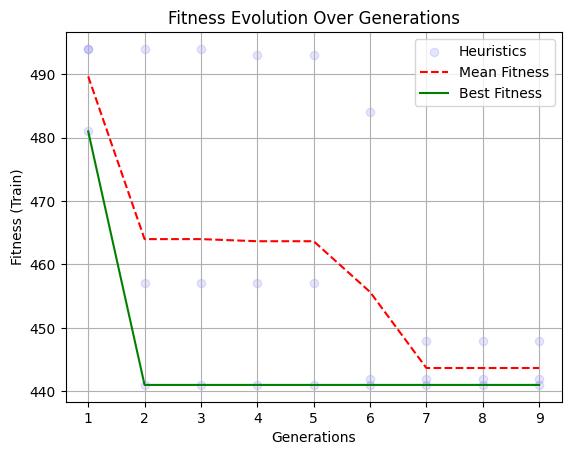

In [16]:
import matplotlib.pyplot as plt
import numpy as np



# Extract data from all_fitness list
generations = np.arange(1, 10)

# Store fitness_train values for calculating mean and best
all_fitness_train_values = []

# Flag to add label only once for scatter plots
scatter_label_added = False

for all_fitness in all_fitness_10.values():
    fitness_train = [f[1] * 20 for f in all_fitness]
    if not scatter_label_added:
        plt.scatter(generations, fitness_train, label='Heuristics', color='blue', alpha=0.1)
        scatter_label_added = True
    else:
        plt.scatter(generations, fitness_train, color='blue', alpha=0.1) # No label for subsequent scatters
    all_fitness_train_values.append(fitness_train)

# Convert to a NumPy array for easier calculations
all_fitness_train_values = np.array(all_fitness_train_values)

# Calculate the mean fitness for each generation
mean_fitness = np.mean(all_fitness_train_values, axis=0)

# Calculate the best fitness (max) for each generation
best_fitness = np.min(all_fitness_train_values, axis=0)

# Plot the mean line
plt.plot(generations, mean_fitness, color='red', linestyle='--', label='Mean Fitness')

# Plot the best line
plt.plot(generations, best_fitness, color='green', linestyle='-', label='Best Fitness')

plt.xlabel("Generations")
plt.ylabel("Fitness (Train)")
plt.title("Fitness Evolution Over Generations")
plt.legend() # Display the legend
plt.grid(True)
plt.show()

In [ ]:
code_cache = {}
all_fitness = []
seed = 0
for i in range(1,10):
    code_file_path = f"paper_output/10_{seed}/results/pops/population_generation_{i}.json"
    with open(code_file_path, "r") as file:
        all_codes = json.load(file)
    _all_fitness = []
    for code_dict in all_codes:
        crappy_code = code_dict["code"]
        objective = code_dict["objective"]
        if crappy_code in code_cache:
            fitness = code_cache[crappy_code]
        else:
            code_cache[crappy_code] = get_fitness(code_dict)
            fitness = code_cache[crappy_code]
        previous_code = crappy_code
        fitness = get_fitness(code_dict)
        _all_fitness.append((fitness,objective))
    all_fitness.append(_all_fitness)

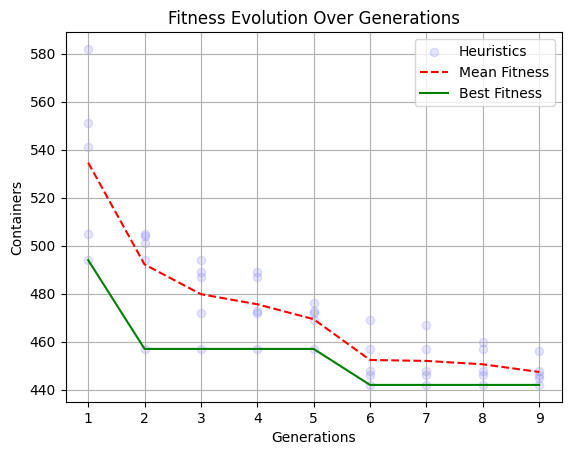

In [34]:
import matplotlib.pyplot as plt
import numpy as np



# Extract data from all_fitness list
generations = np.arange(1, 10)

# Store fitness_train values for calculating mean and best
all_fitness_train_values = np.array(all_fitness)[...,1]*20

# Flag to add label only once for scatter plots
scatter_label_added = False
for p in range(all_fitness_train_values.shape[1]):
    if not scatter_label_added:
        plt.scatter(generations, all_fitness_train_values[..., p], label='Heuristics', color='blue', alpha=0.1)
        scatter_label_added = True
    else:
        plt.scatter(generations, all_fitness_train_values[..., p], color='blue', alpha=0.1) # No label for subsequent scatters

# Calculate the mean fitness for each generation
mean_fitness = np.mean(all_fitness_train_values, axis=1)

# Calculate the best fitness (max) for each generation
best_fitness = np.min(all_fitness_train_values, axis=1)

# Plot the mean line
plt.plot(generations, mean_fitness, color='red', linestyle='--', label='Mean Fitness')

# Plot the best line
plt.plot(generations, best_fitness, color='green', linestyle='-', label='Best Fitness')
plt.xlabel("Generations")
plt.ylabel("Containers")
plt.title("Fitness Evolution Over Generations")
plt.legend() # Display the legend
plt.grid(True)
# Show the plot to pdf
plt.savefig("fitness_evolution.pdf")
plt.show()